In [1]:
import pandas as pd
import numpy as np
import scipy.stats as stats
import warnings
warnings.filterwarnings('ignore')
import matplotlib.pyplot as plt
import time
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Flatten, Dense, Dropout
from tensorflow.keras import optimizers
from tensorflow.keras.callbacks import EarlyStopping
import tensorflow as tf
%matplotlib inline
import xgboost as xgb

import fun1
import noniid

2022-10-11 14:18:03.146928: I tensorflow/core/util/util.cc:169] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2022-10-11 14:18:03.152153: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2022-10-11 14:18:03.152174: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


In [2]:
def create_keras_model(tr_x):
    initializer = tf.keras.initializers.GlorotNormal()
    model = Sequential()
    model.add(Dense(20, activation = 'relu', 
                    input_shape=(tr_x.shape[1],), 
                    kernel_initializer=initializer))
    model.add(Dense(15, activation = 'relu', 
                    kernel_initializer=initializer))
    model.add(Dense(10, activation = 'relu', 
                    kernel_initializer=initializer))
    model.add(Dense(1, activation = 'sigmoid', 
                    kernel_initializer=initializer))
    return model   

In [3]:
def create_and_compile_model(tr_x, merge_w):
    
    model_m4 = create_keras_model(tr_x)
    model_m4.set_weights(merge_w)
    model_m4.compile(optimizer = optimizers.RMSprop(lr=1e-3), 
                     loss = 'binary_crossentropy', 
                     metrics = ['accuracy'])
    return model_m4

In [4]:
from tensorflow.keras.callbacks import EarlyStopping
def model_train_round(
    model_m3, m3_tr_x, m3_tr_y, bs):
    
    callback = EarlyStopping(monitor='loss', 
                             patience=50, 
                             restore_best_weights=True)

    model_m3.fit(m3_tr_x, m3_tr_y, 
                 batch_size = bs, epochs = epo_num, 
                 verbose = 0, callbacks=[callback])  
    return model_m3

In [5]:
def final_non_iid(tr_nn, ts_nn):
    tr_w = tr_nn.layers[-1].get_weights()[0]
    ts_w = ts_nn.layers[-1].get_weights()[0]
    
    tr_ts_w_diff = np.ravel(np.subtract(tr_w, ts_w))
    ori_points = np.zeros(len(tr_ts_w_diff))
    tr_ts_w_diff_norm = np.linalg.norm(
        tr_ts_w_diff - ori_points)
    
    tr_w_norm = np.linalg.norm(
        np.ravel(tr_w) - ori_points)    
    non_iid = tr_ts_w_diff_norm/tr_w_norm
    return non_iid

In [6]:
path = '/home/ai03/_kunyi/pro_shae/datasets/aki_prediction_m4_m3_eicu/'
input_folder = '6tw_6ts_6pre_v1/'
input_dir = path+input_folder

In [7]:
k = 5
percent = 20
sampling_value_ls = list(range(20, 10, -10))
epo_num = 1000
bs = 50
model_types = 'nn'

In [8]:
plot_d1 = 'MIMIC-III'
d1 = 'm3'
d2 = 'm4'
d3 = 'e_0.6'

In [9]:
start_time = time.time()

df_d1 = pd.read_csv(
    input_dir+"6hr_{}_commonFs.csv".format(d1))

df_d2 = pd.read_csv(
    input_dir+"6hr_{}_commonFs.csv".format(d2))

df_d3 = pd.read_csv(
    input_dir +"6hr_{}_commonFs.csv".format(d3))

In [10]:
df_cols = df_d1.columns.tolist()
cat_f_ls = df_cols[4:6]
for i in cat_f_ls:
    df_d1[i] = df_d1[i].astype('category').cat.codes
    df_d2[i] = df_d2[i].astype('category').cat.codes
    df_d3[i] = df_d3[i].astype('category').cat.codes

In [11]:
noniid_ls_trans_ls = []
y_value_ls = []

for s_v in sampling_value_ls:
    print('Sampling {}%'.format(s_v))
    s_v2 = s_v*0.01
    noniid_ls = []   
    
    for r_i in range(1, k+1):    
        print('Round {}'.format(r_i))
        y_value_ls.append(s_v)
        
        df2_d1 = df_d1.sample(frac=s_v2, replace=False)
        df2_d2 = df_d2.sample(frac=s_v2, replace=False)
        df2_d3 = df_d3.sample(frac=s_v2, replace=False)
        df_d1d2 = pd.concat([df2_d1, df2_d2])
        df_d1d3 = pd.concat([df2_d1, df2_d3])   
        
        df1_x, df1_y = fun1.df_xy(df2_d1)
        df2_x, df2_y = fun1.df_xy(df2_d2)       
        df3_x, df3_y = fun1.df_xy(df2_d3)        
        df12_x, df12_y = fun1.df_xy(df_d1d2)
        df13_x, df13_y = fun1.df_xy(df_d1d3)
        
        model_0 = create_keras_model(df1_x)
        w0 = model_0.get_weights()
        
        m1 = create_and_compile_model(df1_x, w0)
        m2 = create_and_compile_model(df2_x, w0)
        m3 = create_and_compile_model(df3_x, w0)
        m12 = create_and_compile_model(df12_x, w0)
        m13 = create_and_compile_model(df13_x, w0)
        
        m1_1 = model_train_round(m1, df1_x, df1_y, bs) 
        m2_1 = model_train_round(m2, df2_x, df2_y, bs) 
        m3_1 = model_train_round(m3, df3_x, df3_y, bs) 
        m12_1 = model_train_round(m12, df12_x, df12_y, bs) 
        m13_1 = model_train_round(m13, df13_x, df13_y, bs) 
            
        d1_non_iid = final_non_iid(m1_1, m1_1) 
        d2_non_iid = final_non_iid(m1_1, m2_1) 
        d3_non_iid = final_non_iid(m1_1, m3_1) 
        d1d2_non_iid = final_non_iid(m1_1, m12_1) 
        d1d3_non_iid = final_non_iid(m1_1, m13_1)  
        
        all_dfs_non_iid_ls = [d1_non_iid, d2_non_iid, 
                              d3_non_iid, d1d2_non_iid, 
                              d1d3_non_iid]
        noniid_ls.append(all_dfs_non_iid_ls)
        
    noniid_ls_trans = np.array(noniid_ls).T
    noniid_ls_trans_ls.append(noniid_ls_trans)

Sampling 20%
Round 1


2022-10-11 14:18:08.251045: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2022-10-11 14:18:08.251161: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcublas.so.11'; dlerror: libcublas.so.11: cannot open shared object file: No such file or directory
2022-10-11 14:18:08.251226: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcublasLt.so.11'; dlerror: libcublasLt.so.11: cannot open shared object file: No such file or directory
2022-10-11 14:18:08.253246: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcusolver.so.11'; dlerror: libcusolver.so.11: cannot open shared object file: No such file or directory
2022-10-11 14:18:08.253316: W tensorflow/stream_executor/platform/default/dso_loader

Round 2
Round 3
Round 4
Round 5


In [12]:
temp_ls = noniid_ls_trans_ls
all_dfs_ls = []

for df_i in range(0, len(all_dfs_non_iid_ls)):
    one_df_temp_ls = []

    for ls_i in range(0, len(sampling_value_ls)):
        one_df_temp_ls.append(temp_ls[ls_i][df_i])
        one_df_temp_ls_1d = np.concatenate(one_df_temp_ls)

    all_dfs_ls.append(one_df_temp_ls_1d)

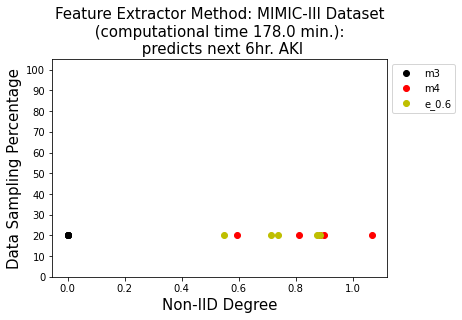

In [13]:
ax = plt.gca()
ax.set_ylim([0, 105])
# ax.set_xlim([-0.05, 1.05])
# plt.xticks(np.arange(0, 1.1, 0.1))
plt.yticks(np.arange(0, 101, 10))

plt.plot(all_dfs_ls[0], y_value_ls, 
         'ko', label='{}'.format(d1))
plt.plot(all_dfs_ls[1], y_value_ls, 
         'ro', label='{}'.format(d2))
plt.plot(all_dfs_ls[2], y_value_ls, 
         'yo', label='{}'.format(d3))
# plt.plot(all_dfs_ls[3], y_value_ls, 
#          'co', label='{} + {}'.format(d1, d2))
# plt.plot(all_dfs_ls[4], y_value_ls, 
#          'go', label='{} + {}'.format(d1, d3))
plt.legend(bbox_to_anchor=(1.0, 1.0), loc='upper left')

end_time = time.time()
elapsed_imte = (end_time - start_time)/60

t_str1 = 'Feature Extractor Method: {} Dataset\n '.format(plot_d1)
plt.title(t_str1+'(computational time {:0.1f} min.): \n predicts next 6hr. AKI'.format(
    elapsed_imte), fontsize=15)  
plt.ylabel('Data Sampling Percentage', fontsize=15)
plt.xlabel('Non-IID Degree', fontsize=15)
plt.savefig("QM2_{}_pre6hr".format(
    plot_d1), bbox_inches='tight')
plt.show()

In [14]:
def get_df(d1, d2, d3, m3_all_dfs_ls, m3_y_value_ls, elapsed_imte, percent):
    x, y = '_x', '_y'
    df_ts1 = pd.DataFrame(columns=[d1+x, d1+y, d2+x, 
                                   d2+y, d3+x, d3+y])
    df_ts2 = df_ts1.copy()
    for xi, li in zip(range(0, 5, 2), range(0,3)):
        df_ts2[df_ts2.columns.tolist()[xi]] = m3_all_dfs_ls[li]
        df_ts2[df_ts2.columns.tolist()[xi+1]] = m3_y_value_ls
    df_ts2.to_csv("M4_{}_time_{:0.1f}_non_iid_{}_percentage.csv".format(
        d1, elapsed_imte, percent), index=False)   
    return df_ts2

In [15]:
output_df = get_df(d1, d2, d3, 
                   all_dfs_ls, y_value_ls, 
                   elapsed_imte, percent)
output_df.head()

,m3_x,m3_y,m4_x,m4_y,e_0.6_x,e_0.6_y
0,0.0,20,0.811445,20,0.715559,20
1,0.0,20,0.595896,20,0.548288,20
2,0.0,20,0.886013,20,0.884903,20
3,0.0,20,1.067877,20,0.875098,20
4,0.0,20,0.899837,20,0.737181,20
